# RHESSI flare from temporal decomposition paper
Here we analyze the 2011 Jul 30 flare observed by RHESSI from the temporal decomposition paper.

We don't perform spectroscopy; we just demonstrate the decomposition technique.

## How to: set up this package
Please see the `readme.md` file in the root of this repository.

## How to: get data
The RHESSI flare is downloaded using SSWIDL routines.
An appropriate SSWIDL license and installation is required to parse the level zero RHESSI data into a spectrogram.
See `rhessi_download.pro` to get the details.

In [1]:
from sunkit_spex.extern import rhessi
from yaff.plotting import stairs_with_error

import astropy.units as u
import astropy.time as atime
from astropy.visualization import quantity_support
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tedec import decomp

## Load in the data and perform the temporal decomposition

### First, load the data and slice out the time range we want

In [2]:
def nearest(a, v):
    return np.argmin(np.abs(a - v))


spectrum_file = "trevor-flare-30-jul-2011-logspace-bkg_spec.fits"
srm_file = "trevor-flare-30-jul-2011-logspace-bkg_srm.fits"

data = rhessi.RhessiLoader(spectrum_fn=spectrum_file, srm_fn=srm_file)

start_event_time = atime.Time("2011-07-30T02:08:40")
end_event_time = atime.Time("2011-07-30T02:09:00")
start_background_time = atime.Time("2011-07-30T01:54:00")
end_background_time = atime.Time("2011-07-30T01:56:00")

data.update_event_times(start_event_time, end_event_time)
data.update_background_times(start_background_time, end_background_time)

/home/william/dev/tedec/.venv/lib/python3.13/site-packages/sunkit_spex/extern/rhessi.py:196: UserWarning: 
do not update event times to (2011-07-30T01:50:00.000, 2011-07-30T02:20:00.000): covers attenuator state change. Don't trust this fit!
  warnings.warn(


### Slice out the data from sunkit-spex format into a simplified data structure

In [3]:
def prep_rhessi_data(rl: rhessi.RhessiLoader) -> dict[str, u.Quantity]:
    """Take a sunkit_spex object and extract the data we want from it"""
    tbins = atime.Time(
        np.concatenate(
            (rl._spectrum["time_bins"][:, 0], [rl._spectrum["time_bins"][-1, -1]])
        )
    )
    ebins = np.unique(rl["count_channel_bins"].flatten()) << u.keV

    cts = rl._spectrum["counts"] / rl._spectrum["livetime"]
    err = rl._spectrum["counts_err"] / rl._spectrum["livetime"]

    tai, tbi = (
        nearest(tbins, atime.Time(rl._start_event_time)),
        nearest(tbins, atime.Time(rl._end_event_time)),
    )
    cut_cts = cts[tai:tbi] << u.ct
    cut_err = err[tai:tbi] << u.ct
    cut_tbins = tbins[tai : tbi + 1]

    return {
        "time_bins": cut_tbins,
        "energy_bins": ebins,
        "cts": cut_cts.T,
        "cts_err": cut_err.T,
    }

In [4]:
sliced = prep_rhessi_data(data)

### Then, perform the decomposition

In [5]:
# We want to apply any sort of lightcurve summations by indexing the
# energy midpoints, as they have the same shape as the counts.
energy_mids = sliced["energy_bins"][:-1] + np.diff(sliced["energy_bins"]) / 2

# Template energies for (thermal, nonthermal, background).
TH_ENG = 5.5 << u.keV
NTH_ENG = 81 << u.keV

# Find the indices of the count bins that are closest to our desired energies
th_idx = nearest(TH_ENG, energy_mids)
nth_idx = nearest(NTH_ENG, energy_mids)

# Package up all of our data into a DataPacket
pack = decomp.DataPacket(
    data=sliced["cts"],
    basis_timeseries=[
        # Take a few thermal and nonthermal and bkg energy bands and sum them
        # together to make the basis timeseries.
        # This helps with statistics and also makes it so that
        # no single energy band dominates the behavior of the emission
        sliced["cts"][th_idx - 1 : th_idx + 2].sum(axis=0),
        sliced["cts"][nth_idx - 1 : nth_idx + 2].sum(axis=0),
        sliced["cts"][-1],
    ],
    # In this case, because we are using a background light curve,
    # we want no constant offset.
    constant_offset=False,
)

# Decompose the data using the `decomp` module
# See the docstring for more info
decomposed = decomp.bootstrap(
    dp=pack, errors=sliced["cts_err"], num_iter=3000, clip_negative=True
)

## Plot the decomposed data on top of the original data

[Text(0.5, 1.0, 'RHESSI decomposition'), None, None, (0.01, 2000.0)]

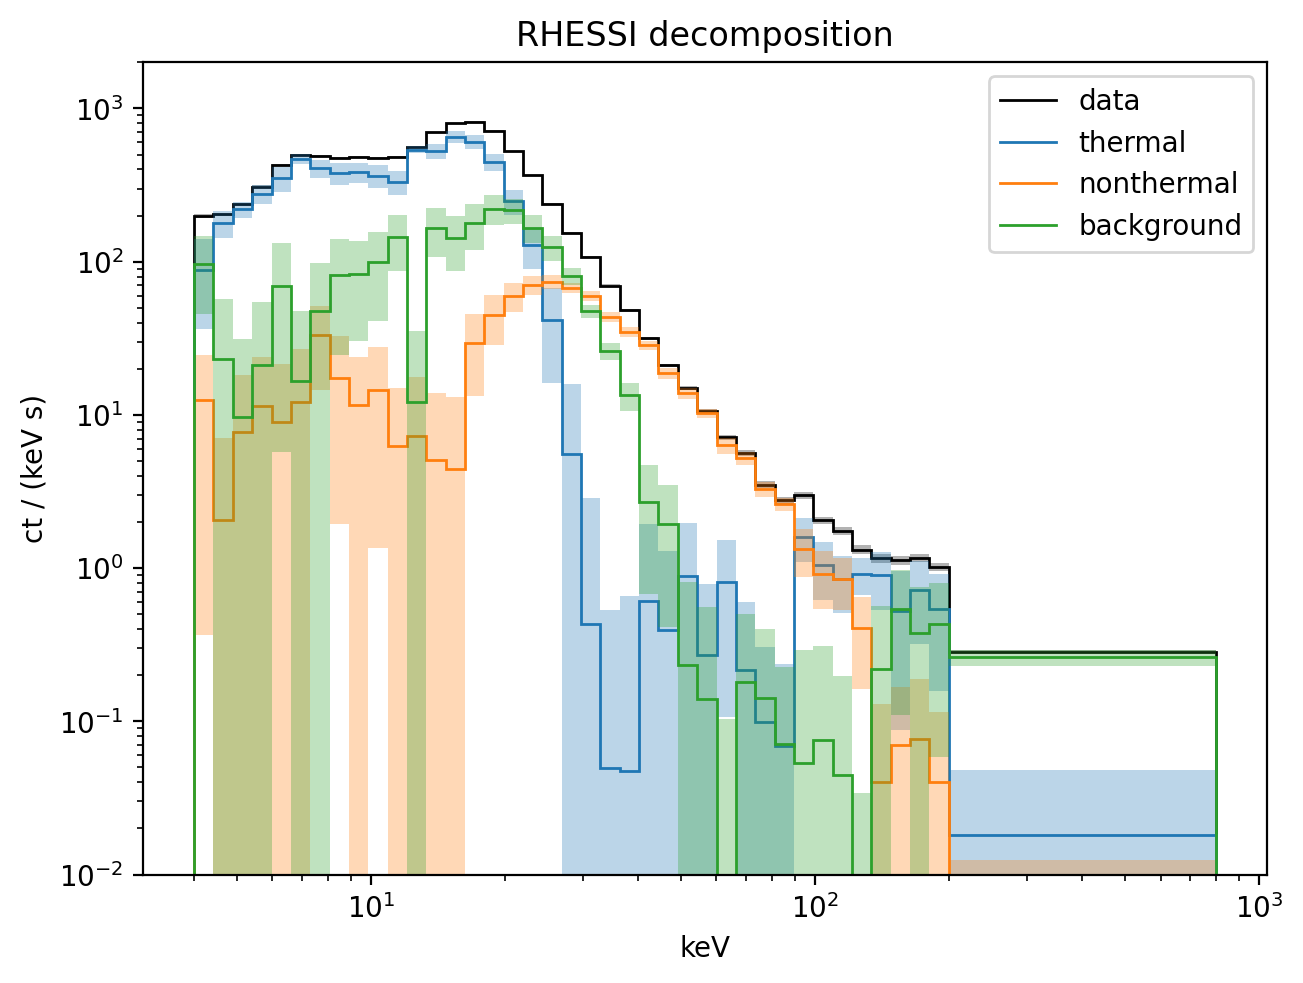

In [6]:
# As per the docstring, the decomposed data are the first N-1 entries, while the
# intercept is included in the final entry.
index_map = {"thermal": 0, "nonthermal": 1, "background": 2}

# Energy binning is nonuniform, so we divide it out
# for a nicer looking spectrum
de = np.diff(sliced["energy_bins"]) << u.keV

# Average the live time across all detector pairs
dt = np.sum(np.diff(sliced["time_bins"])).to(u.s)

fig, ax = plt.subplots(layout="constrained")

all_counts = sliced["cts"].sum(axis=1)
all_errors = np.sqrt(np.sum(sliced["cts_err"] ** 2, axis=1))

with quantity_support():
    stairs_with_error(
        sliced["energy_bins"],
        all_counts / de / dt,
        all_errors / de / dt,
        ax=ax,
        label="data",
        line_kw={"color": "black"},
    )
    for label, index in index_map.items():
        # Get the samples associated with your pseudobasis
        samples = decomposed[:, index, :]
        avg_cts = np.mean(samples, axis=0) << u.ct
        avg_std = np.std(samples, axis=0) << u.ct

        stairs_with_error(
            sliced["energy_bins"],
            avg_cts / de / dt,
            avg_std / de / dt,
            ax=ax,
            label=label,
        )

ax.legend()
ax.set(
    title="RHESSI decomposition",
    xscale="log",
    yscale="log",
    # xlim=(4, 300),
    ylim=(0.01, 2e3),
)

### We can see that the decomposed data captures the various components well. There is an excess in the background that we attribute to a hot thermal component.
### This is equivalent to Figure 4 from the paper.